In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import scipy.stats as ss
from scipy.stats import expon, norm, gamma, beta, lognorm
from scipy.stats._continuous_distns import beta_gen, gamma_gen
from scipy import stats
from datetime import datetime, timedelta

# EDA

## Daten einlesen

In [2]:
def trim_non_visible(s):
    """Strip if s is a string, otherwise return s."""
    if isinstance(s, str):
        return s.strip()
    return s


def read_data(file):
    """Reads the first 4 columns from the given file and drops empty rows."""
    data = pd.read_csv(
        file, delimiter=",", usecols=[0, 1, 2, 3], parse_dates=[[0, 1]]
    )
    data.columns = ["datetime", "kg", "m/s"]
    data = data[data["datetime"] != "nan nan"]
    data = data.dropna(how="all")
    data["datetime"] = pd.to_datetime(data["datetime"])
    data = data.applymap(trim_non_visible)
    return data.sort_values(by=["datetime"])

In [3]:
zone1 = read_data("data/out_1.csv")
zone2 = read_data("data/out_2.csv")

In [4]:
pd.concat([zone1, zone2], axis=1, keys=["zone1", "zone2"]).describe()

zone1                           
                            datetime           kg        m/s   
count                             68    68.000000  68.000000  \
mean   2019-02-12 22:08:49.411764736   628.632353   8.788235   
min              2019-01-01 09:00:00    12.000000   3.600000   
25%              2019-01-23 23:00:00   214.750000   7.300000   
50%              2019-02-14 03:00:00   402.500000   8.800000   
75%              2019-03-03 09:30:00   773.000000  10.125000   
max              2019-03-27 16:00:00  3104.000000  14.100000   
std                              NaN   695.884703   1.989189   

                     zone2                         
                  datetime          kg        m/s  
count                   32   32.000000  32.000000  
mean   2019-02-11 15:48:45   99.250000  37.790625  
min    2019-01-01 09:00:00    0.000000  24.900000  
25%    2019-01-17 17:00:00   36.750000  33.200000  
50%    2019-02-12 12:30:00   58.000000  38.750000  
75%    2019-03-10 17:45:00  140.000000  41.725000  
max    2019-03-28 01:00:00  406.000000  46.500000  
std                    NaN  104.072555   5.395778

In [5]:
zone1.head()

,datetime,kg,m/s
0,2019-01-01 09:00:00,194.0,8.4
1,2019-01-01 21:00:00,224.0,8.8
2,2019-01-02 14:00:00,3104.0,9.2
3,2019-01-04 15:00:00,228.0,8.0
4,2019-01-05 23:00:00,755.0,7.0


In [6]:
print(zone2.isna().sum())

datetime    0
kg          0
m/s         0
dtype: int64


## NAs

In [7]:
# Check for NaN values
print(zone1.isna().sum())

# Check for zeros
print(zone1.eq(0).sum())

datetime    0
kg          0
m/s         0
dtype: int64
datetime    0
kg          0
m/s         0
dtype: int64


In [8]:
# Drop lines with only NA values
zone1 = zone1.dropna(how="all")
print(zone1.isna().sum())

datetime    0
kg          0
m/s         0
dtype: int64


In [9]:
# Check for NaN values
print(zone2.isna().sum())

# Check for zeros
print(zone2.eq(0).sum())

datetime    0
kg          0
m/s         0
dtype: int64
datetime    0
kg          1
m/s         0
dtype: int64


Ein Stein hat keine Masse und muss beachtet werden.

In [10]:
# Drop lines with only NA values
zone2 = zone2.dropna(how="all")
print(zone2.isna().sum())

datetime    0
kg          0
m/s         0
dtype: int64


## Stein mit 0 Masse

In [11]:
# Set the value to the median in the row where 'kg' equals 0.0
# This rock is not removed from the data, because we do not have a lot of data and this might just have been an error in the measurement
zone2.loc[zone2["kg"] == 0.0, "kg"] = zone2["kg"].median()
# TODO: try to drop the row and check if there is a difference? or go up to 1? -> how do the parameters change (don't run simulation)?

In [12]:
pd.concat([zone1, zone2], axis=1, keys=["zone1", "zone2"]).describe()

zone1                           
                            datetime           kg        m/s   
count                             68    68.000000  68.000000  \
mean   2019-02-12 22:08:49.411764736   628.632353   8.788235   
min              2019-01-01 09:00:00    12.000000   3.600000   
25%              2019-01-23 23:00:00   214.750000   7.300000   
50%              2019-02-14 03:00:00   402.500000   8.800000   
75%              2019-03-03 09:30:00   773.000000  10.125000   
max              2019-03-27 16:00:00  3104.000000  14.100000   
std                              NaN   695.884703   1.989189   

                     zone2                         
                  datetime          kg        m/s  
count                   32   32.000000  32.000000  
mean   2019-02-11 15:48:45  101.062500  37.790625  
min    2019-01-01 09:00:00    3.000000  24.900000  
25%    2019-01-17 17:00:00   37.750000  33.200000  
50%    2019-02-12 12:30:00   58.000000  38.750000  
75%    2019-03-10 17:45:00  140.000000  41.725000  
max    2019-03-28 01:00:00  406.000000  46.500000  
std                    NaN  102.785382   5.395778

In [13]:
print(zone2.eq(0).sum())

datetime    0
kg          0
m/s         0
dtype: int64


## Energie und Zeitdifferenz berechnen

In [14]:
def _get_time_differences(df):
    """Returns the time differences between rocks in hours."""
    return df["datetime"].diff().dt.total_seconds() / 3600


def add_time_differences(df):
    """Adds the time differences to the dataframe."""
    df["timediv h"] = _get_time_differences(df)

    # TODO: why median?
    # replace NA with 0 in the column timediv h
    df["timediv h"] = df["timediv h"].fillna(0)
    # replace 0 with median of timediv h in the column timediv h
    df["timediv h"] = df["timediv h"].replace(0, df["timediv h"].median())

    return df


def add_energy(df):
    """Adds the energy to the dataframe."""
    df["kj"] = 0.5 * df["kg"] * df["m/s"] ** 2 / 1000
    return df

In [15]:
zone1 = add_time_differences(add_energy(zone1))
zone2 = add_time_differences(add_energy(zone2))
print(zone1.head())
print(zone2.head())

             datetime      kg  m/s         kj  timediv h
0 2019-01-01 09:00:00   194.0  8.4    6.84432       22.0
1 2019-01-01 21:00:00   224.0  8.8    8.67328       12.0
2 2019-01-02 14:00:00  3104.0  9.2  131.36128       17.0
3 2019-01-04 15:00:00   228.0  8.0    7.29600       49.0
4 2019-01-05 23:00:00   755.0  7.0   18.49750       32.0
             datetime     kg   m/s         kj  timediv h
0 2019-01-01 09:00:00   38.0  45.4   39.16204       48.5
1 2019-01-03 06:00:00  187.0  41.6  161.80736       45.0
2 2019-01-04 10:00:00   36.0  44.6   35.80488       28.0
3 2019-01-07 14:00:00    6.0  41.2    5.09232       76.0
4 2019-01-11 06:00:00   65.0  39.6   50.96520       88.0


## Visualizierung

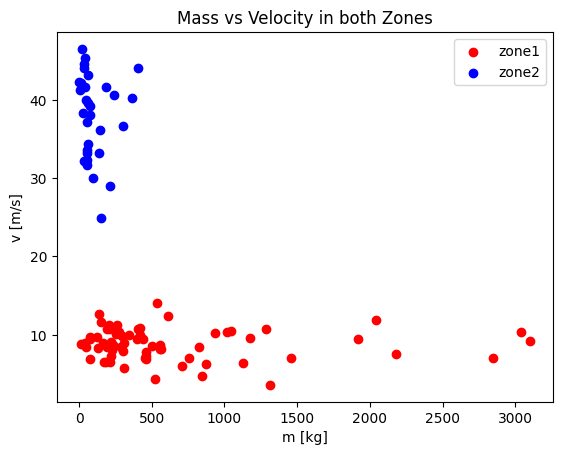

In [16]:
fig, ax = plt.subplots()
ax.scatter(zone1["kg"], zone1["m/s"], c="red", label="zone1")
ax.scatter(zone2["kg"], zone2["m/s"], c="blue", label="zone2")
ax.legend()
ax.axes.set_xlabel("m [kg]")
ax.axes.set_ylabel("v [m/s]")
plt.title("Mass vs Velocity in both Zones")
plt.show()

Zonen 1 und 2 sollten nicht gemischt werden, da sie nicht teil von der gleichen Grundgesamtheit sind.

In [17]:
def scatter_plot(
    df: pd.DataFrame,
    col: str,
    colorbar=False,
    title=None,
):
    """Plots the given column of the given data frame as a scatter plot."""
    if title is None:
        title = f"{col.upper()} vs. Date"
    title = title + f"\nnumber of records: {len(df)}"
    df["datetime"] = pd.to_datetime(df["datetime"])
    ax = df.plot.scatter(x="datetime", y=col, colorbar=colorbar)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.title(
        f"{col} vs. date\nnumber of records: {len(df)}"
        if title is None
        else title
    )
    plt.xticks(rotation=90)


def plot_histogram(df: pd.DataFrame, col: str, zone: int, title: str = None):
    """Plots the given column of the given dataframe as a histogram."""
    if title is None:
        title = f"{col.upper()} for Zone {zone}"
    title = title + f"\nnumber of records: {len(df)}"
    df[col].hist(bins=np.sqrt(len(df[col])).astype(int) * 6)
    plt.xlabel(col.upper())
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

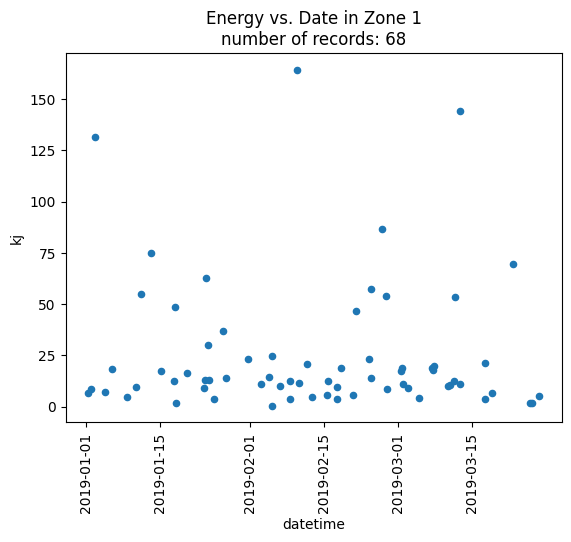

In [18]:
scatter_plot(zone1, "kj", title="Energy vs. Date in Zone 1")

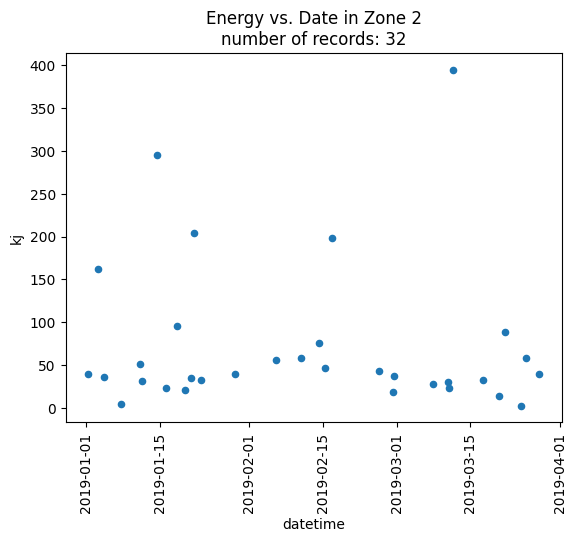

In [19]:
scatter_plot(zone2, "kj", title="Energy vs. Date in Zone 2")

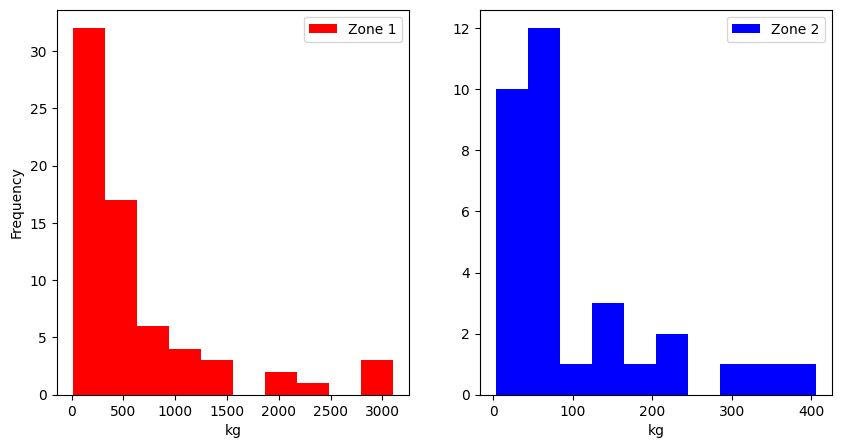

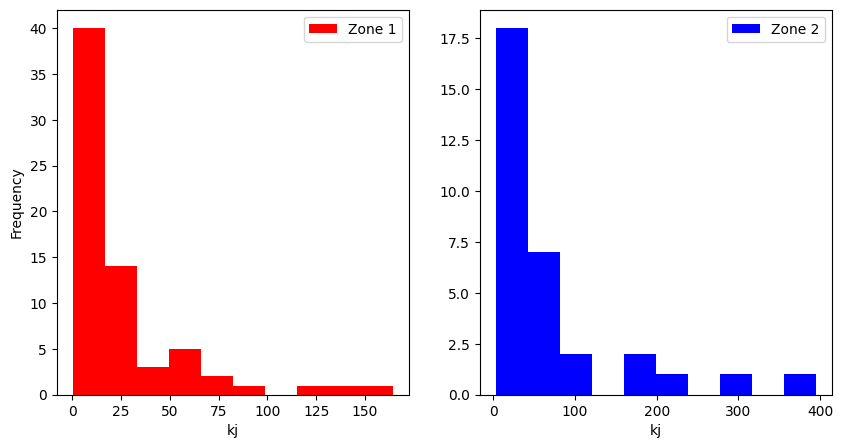

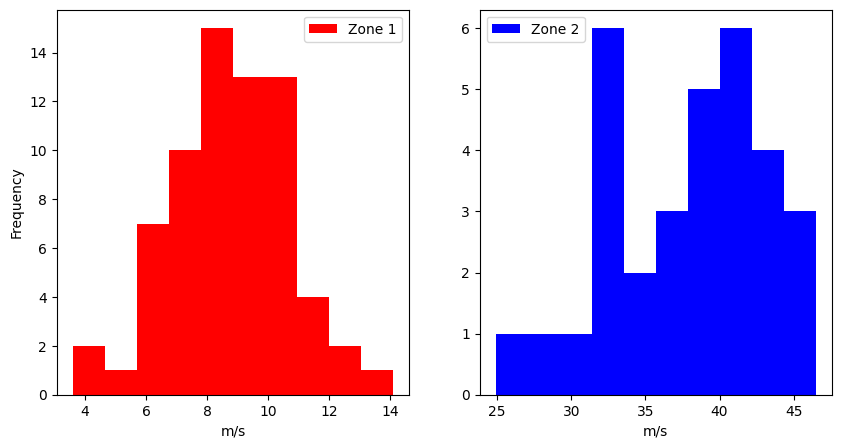

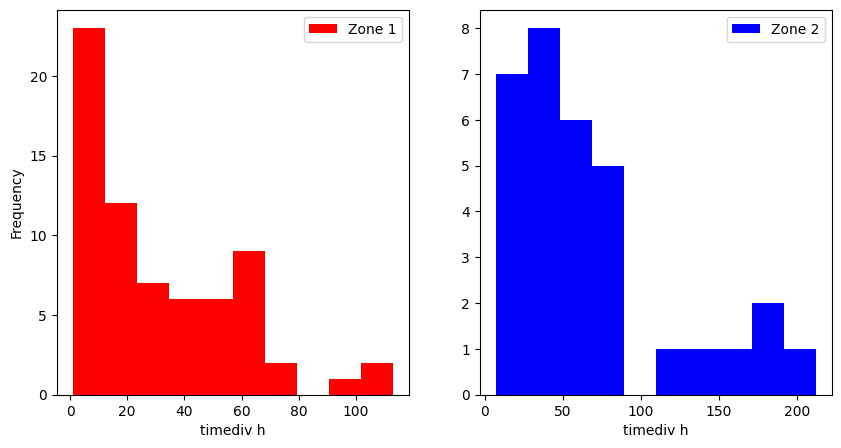

In [20]:
num_bins = 10

# Plot the histograms for 'kg'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["kg"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["kg"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("kg")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("kg")
ax2.legend()
plt.show()

# Plot the histograms for 'kj'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["kj"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["kj"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("kj")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("kj")
ax2.legend()
plt.show()

# Plot the histograms for 'm/s'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["m/s"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["m/s"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("m/s")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("m/s")
ax2.legend()
plt.show()

# Plot the histograms for 'timediv h'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["timediv h"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["timediv h"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("timediv h")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("timediv h")
ax2.legend()
plt.show()

In [21]:
pd.concat([zone1, zone2], axis=1, keys=["zone1", "zone2"]).describe()

zone1                                       
                            datetime           kg        m/s          kj   
count                             68    68.000000  68.000000   68.000000  \
mean   2019-02-12 22:08:49.411764736   628.632353   8.788235   25.197761   
min              2019-01-01 09:00:00    12.000000   3.600000    0.464640   
25%              2019-01-23 23:00:00   214.750000   7.300000    8.214900   
50%              2019-02-14 03:00:00   402.500000   8.800000   12.815133   
75%              2019-03-03 09:30:00   773.000000  10.125000   23.135955   
max              2019-03-27 16:00:00  3104.000000  14.100000  164.403200   
std                              NaN   695.884703   1.989189   32.704933   

                                 zone2                                      
        timediv h             datetime          kg        m/s          kj   
count   68.000000                   32   32.000000  32.000000   32.000000  \
mean    31.073529  2019-02-11 15:48:45  101.062500  37.790625   72.543707   
min      1.000000  2019-01-01 09:00:00    3.000000  24.900000    2.683935   
25%      6.750000  2019-01-17 17:00:00   37.750000  33.200000   29.600176   
50%     22.000000  2019-02-12 12:30:00   58.000000  38.750000   39.581020   
75%     49.000000  2019-03-10 17:45:00  140.000000  41.725000   63.103560   
max    113.000000  2019-03-28 01:00:00  406.000000  46.500000  394.796430   
std     27.085997                  NaN  102.785382   5.395778   87.452601   

                   
        timediv h  
count   32.000000  
mean    65.765625  
min      7.000000  
25%     28.750000  
50%     50.250000  
75%     77.250000  
max    212.000000  
std     54.372815

In [22]:
# TODO: understan log-likelihood/MLE
# TODO: what other strategies are there to evaluate how good distributions fit the data?
# TODO: compare distributions VS fitting parameters of one distribution to the data: two different problems/solutions
def cdf_fit(data):
    distributions = [ss.norm, ss.lognorm, ss.expon, ss.gamma]

    # Plot the CDF of the data and the fitted distributions
    plt.hist(
        data,
        bins=len(data),
        density=True,
        cumulative=True,
        alpha=0.5,
        label="Data",
    )
    x = np.linspace(data.min(), data.max() * 1.2, 100)

    for dist in distributions:
        params = dist.fit(data)
        ll = -dist.logpdf(data, *params).sum().round(0)
        plt.plot(x, dist(*params).cdf(x), label=f"{dist.name}, score: {ll}")
        plt.xlabel(data.name)
        plt.ylabel("Cumulative probability")
        plt.legend()

    plt.show()

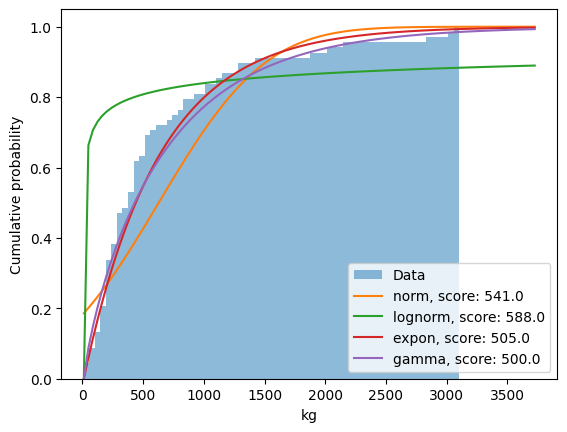

In [23]:
cdf_fit(zone1["kg"])

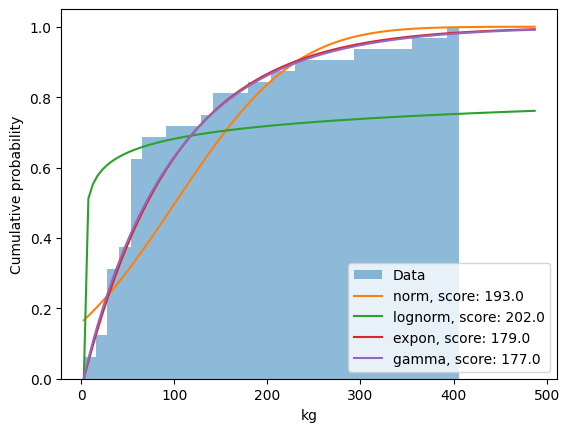

In [24]:
cdf_fit(zone2["kg"])

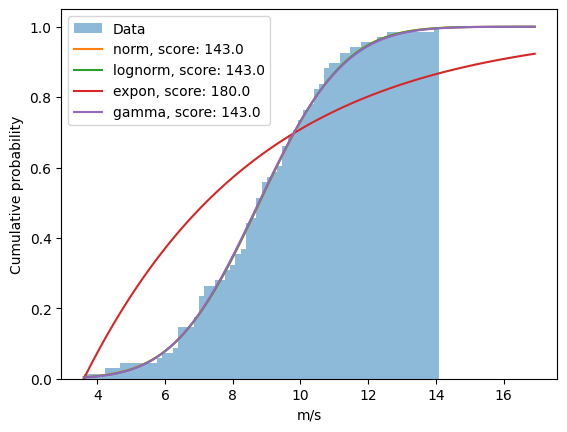

In [25]:
cdf_fit(zone1["m/s"])

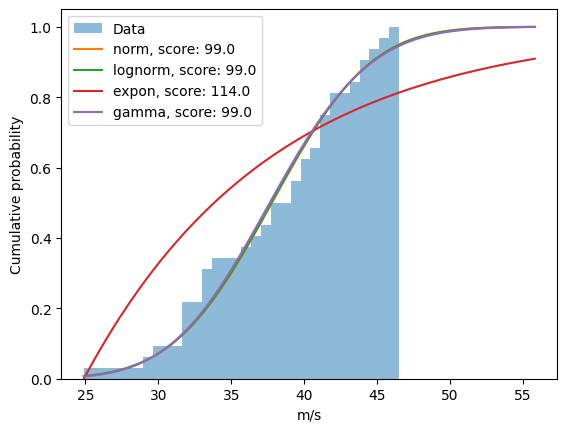

In [26]:
cdf_fit(zone2["m/s"])

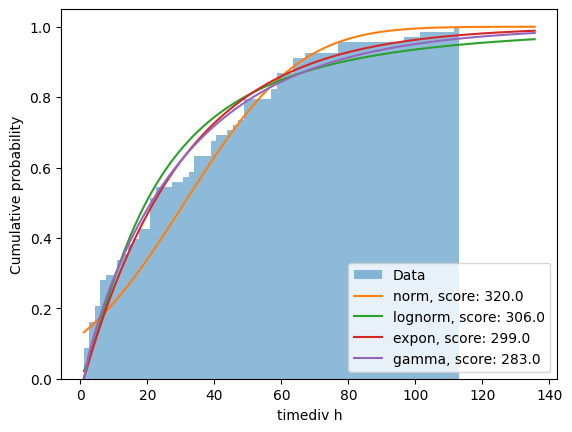

In [27]:
cdf_fit(zone1["timediv h"])

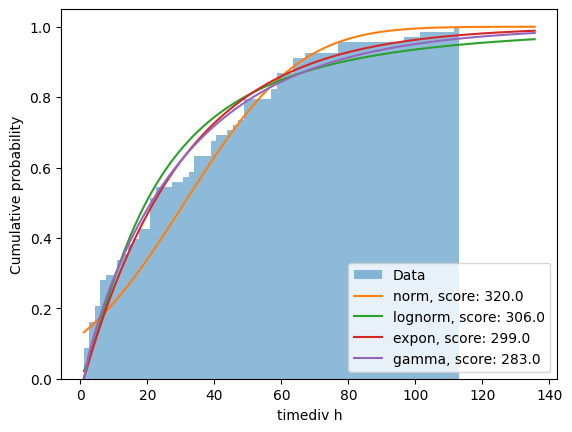

In [28]:
cdf_fit(zone1["timediv h"])

In [29]:
# to simulate a dataframe for the next number of years it will estimate the number of events it takes and generate a frame
def simulate_zone(zone_df, num_years=200):
    timediv_mean = zone_df["timediv h"].mean()

    # Calculate  the deviation
    timediv_params = expon.fit(zone_df["timediv h"])
    kg_params = gamma.fit(zone_df["kg"])
    v_params = norm.fit(zone_df["m/s"])
    # Calculate number of observations for given number of years
    total_hours = num_years * 365.25 * 24
    num_observations = int(total_hours / timediv_mean)

    # Set the starting datetime to January 1st, 2000, 00:00:00
    current_datetime = datetime(2000, 1, 1, 0, 0, 0)

    # Initialize the new dataframe and generate the data
    simulated_df = pd.DataFrame(index=range(num_observations))
    simulated_df["timediv h"] = (
        expon(*timediv_params).rvs(size=num_observations).round(0)
    )
    simulated_df["datetime"] = (
        simulated_df["timediv h"]
        .cumsum()
        .apply(lambda x: current_datetime + timedelta(hours=x))
    )
    simulated_df["kg"] = gamma(*kg_params).rvs(size=num_observations).round(0)
    simulated_df["m/s"] = norm(*v_params).rvs(size=num_observations).round(1)
    simulated_df["kj"] = (
        0.5 * simulated_df["kg"] * (simulated_df["m/s"] ** 2) / 1000
    )

    return simulated_df

In [30]:
# simulated zones
simulated1 = simulate_zone(zone1)
simulated1["zone"] = 1
simulated2 = simulate_zone(zone2)
simulated2["zone"] = 2
simulated1.describe()
# m/s is the min 0 which is not possible

,timediv h,datetime,kg,m/s,kj,zone
count,56421.000000,56421,56421.000000,56421.000000,56421.000000,56421.0
mean,31.101097,2100-01-16 21:51:25.276758528,678.993017,8.786608,27.573727,1.0
min,1.000000,2000-01-01 19:00:00,12.000000,-0.100000,0.003855,1.0
25%,10.000000,2050-04-06 05:00:00,161.000000,7.400000,5.525370,1.0
50%,22.000000,2099-09-21 04:00:00,433.000000,8.800000,15.395220,1.0
75%,43.000000,2150-03-12 12:00:00,929.000000,10.100000,35.966980,1.0
max,339.000000,2200-03-07 19:00:00,8193.000000,16.600000,843.831450,1.0
std,30.236274,NaN,741.444701,1.980514,34.907274,0.0


In [31]:
pd.concat([zone1, simulated1], axis=1, keys=["zone1", "simulated1"]).describe()

zone1                                       
                            datetime           kg        m/s          kj   
count                             68    68.000000  68.000000   68.000000  \
mean   2019-02-12 22:08:49.411764736   628.632353   8.788235   25.197761   
min              2019-01-01 09:00:00    12.000000   3.600000    0.464640   
25%              2019-01-23 23:00:00   214.750000   7.300000    8.214900   
50%              2019-02-14 03:00:00   402.500000   8.800000   12.815133   
75%              2019-03-03 09:30:00   773.000000  10.125000   23.135955   
max              2019-03-27 16:00:00  3104.000000  14.100000  164.403200   
std                              NaN   695.884703   1.989189   32.704933   

                     simulated1                                                
        timediv h     timediv h                       datetime            kg   
count   68.000000  56421.000000                          56421  56421.000000  \
mean    31.073529     31.101097  2100-01-16 21:51:25.276758528    678.993017   
min      1.000000      1.000000            2000-01-01 19:00:00     12.000000   
25%      6.750000     10.000000            2050-04-06 05:00:00    161.000000   
50%     22.000000     22.000000            2099-09-21 04:00:00    433.000000   
75%     49.000000     43.000000            2150-03-12 12:00:00    929.000000   
max    113.000000    339.000000            2200-03-07 19:00:00   8193.000000   
std     27.085997     30.236274                            NaN    741.444701   

                                            
                m/s            kj     zone  
count  56421.000000  56421.000000  56421.0  
mean       8.786608     27.573727      1.0  
min       -0.100000      0.003855      1.0  
25%        7.400000      5.525370      1.0  
50%        8.800000     15.395220      1.0  
75%       10.100000     35.966980      1.0  
max       16.600000    843.831450      1.0  
std        1.980514     34.907274      0.0

In [32]:
simulated2.head()

,timediv h,datetime,kg,m/s,kj,zone
0,168.0,2000-01-08 00:00:00,13.0,33.2,7.16456,2
1,73.0,2000-01-11 01:00:00,126.0,24.8,38.74752,2
2,16.0,2000-01-11 17:00:00,27.0,37.2,18.68184,2
3,12.0,2000-01-12 05:00:00,18.0,42.9,16.56369,2
4,242.0,2000-01-22 07:00:00,80.0,29.9,35.76040,2


In [33]:
simulated2.tail()

,timediv h,datetime,kg,m/s,kj,zone
26653,65.0,2201-04-16 00:00:00,47.0,29.0,19.763500,2
26654,117.0,2201-04-20 21:00:00,10.0,27.2,3.699200,2
26655,34.0,2201-04-22 07:00:00,75.0,36.9,51.060375,2
26656,60.0,2201-04-24 19:00:00,89.0,31.3,43.596205,2
26657,21.0,2201-04-25 16:00:00,26.0,31.3,12.735970,2


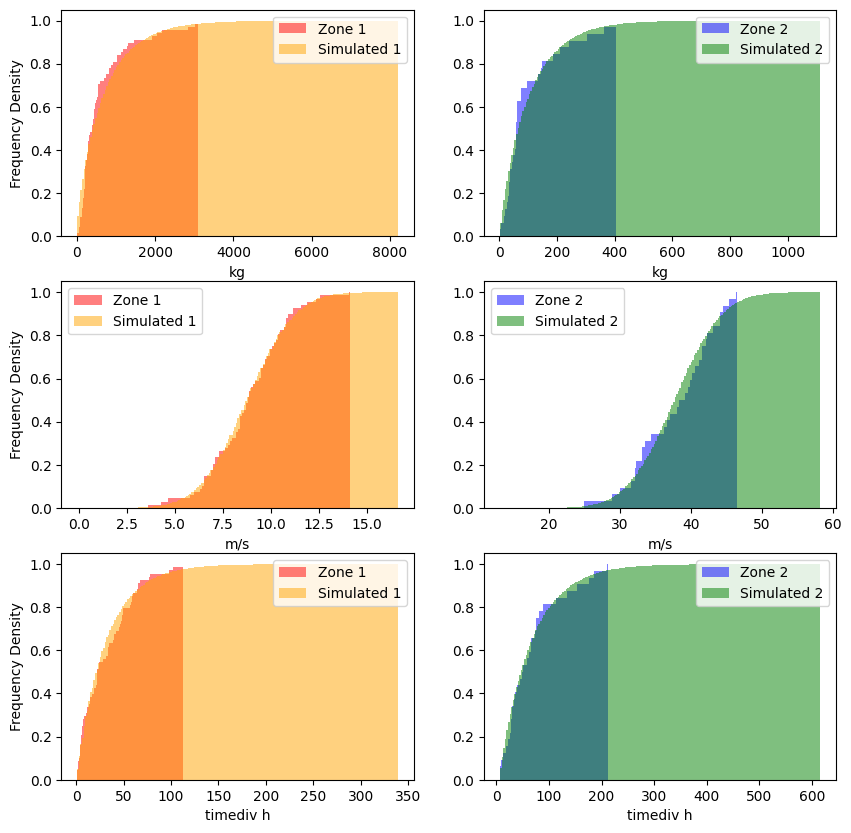

In [34]:
# Set variables
num_bins = 200
cumulative = True

# Plot the histograms for 'kg', 'm/s', and 'timediv h'
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    3, 2, figsize=(10, 10)
)

# Histogram for 'kg'
ax1.hist(
    zone1["kg"],
    bins=num_bins,
    color="red",
    alpha=0.5,
    label="Zone 1",
    density=True,
    cumulative=cumulative,
)
ax1.hist(
    simulated1["kg"],
    bins=num_bins,
    color="orange",
    alpha=0.5,
    label="Simulated 1",
    density=True,
    cumulative=cumulative,
)
ax2.hist(
    zone2["kg"],
    bins=num_bins,
    color="blue",
    alpha=0.5,
    label="Zone 2",
    density=True,
    cumulative=cumulative,
)
ax2.hist(
    simulated2["kg"],
    bins=num_bins,
    color="green",
    alpha=0.5,
    label="Simulated 2",
    density=True,
    cumulative=cumulative,
)

ax1.set_xlabel("kg")
ax1.set_ylabel("Frequency Density")
ax1.legend()
ax2.set_xlabel("kg")
ax2.legend()

# Histogram for 'm/s'
ax3.hist(
    zone1["m/s"],
    bins=num_bins,
    color="red",
    alpha=0.5,
    label="Zone 1",
    density=True,
    cumulative=cumulative,
)
ax3.hist(
    simulated1["m/s"],
    bins=num_bins,
    color="orange",
    alpha=0.5,
    label="Simulated 1",
    density=True,
    cumulative=cumulative,
)
ax4.hist(
    zone2["m/s"],
    bins=num_bins,
    color="blue",
    alpha=0.5,
    label="Zone 2",
    density=True,
    cumulative=cumulative,
)
ax4.hist(
    simulated2["m/s"],
    bins=num_bins,
    color="green",
    alpha=0.5,
    label="Simulated 2",
    density=True,
    cumulative=cumulative,
)

ax3.set_xlabel("m/s")
ax3.set_ylabel("Frequency Density")
ax3.legend()
ax4.set_xlabel("m/s")
ax4.legend()

# Histogram for 'timediv h'
ax5.hist(
    zone1["timediv h"],
    bins=num_bins,
    color="red",
    alpha=0.5,
    label="Zone 1",
    density=True,
    cumulative=cumulative,
)
ax5.hist(
    simulated1["timediv h"],
    bins=num_bins,
    color="orange",
    alpha=0.5,
    label="Simulated 1",
    density=True,
    cumulative=cumulative,
)
ax6.hist(
    zone2["timediv h"],
    bins=num_bins,
    color="blue",
    alpha=0.5,
    label="Zone 2",
    density=True,
    cumulative=cumulative,
)
ax6.hist(
    simulated2["timediv h"],
    bins=num_bins,
    color="green",
    alpha=0.5,
    label="Simulated 2",
    density=True,
    cumulative=cumulative,
)

ax5.set_xlabel("timediv h")
ax5.set_ylabel("Frequency Density")
ax5.legend()
ax6.set_xlabel("timediv h")
ax6.legend()

plt.show()

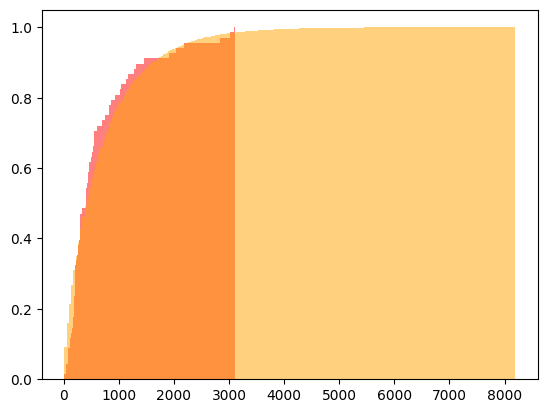

In [35]:
def compare_simulated_to_original(
    original_column, simulated_column, num_bins=200, cumulative=True
):
    plt.hist(
        original_column,
        bins=num_bins,
        color="red",
        alpha=0.5,
        label="Zone 1",
        density=True,
        cumulative=cumulative,
    )
    plt.hist(
        simulated_column,
        bins=num_bins,
        color="orange",
        alpha=0.5,
        label="Simulated 1",
        density=True,
        cumulative=cumulative,
    )

    ax1.set_xlabel(original_column.name)
    ax1.set_ylabel("Frequency Density")
    ax1.legend()


compare_simulated_to_original(zone1["kg"], simulated1["kg"])

In [36]:
# Determine the latest end datetime of the two dataframes
max_datetime = min(simulated1["datetime"].max(), simulated2["datetime"].max())

# Set the end datetime of both dataframes to be the same
simulated1 = simulated1[simulated1["datetime"] <= max_datetime]
simulated2 = simulated2[simulated2["datetime"] <= max_datetime]

# Merge the two dataframes together, sort by datetime, and reset the index
simulated_df = pd.concat([simulated1, simulated2])
simulated_df = simulated_df.sort_values("datetime")
simulated_df = simulated_df.reset_index(drop=True)

In [37]:
simulated_df.describe()

,timediv h,datetime,kg,m/s,kj,zone
count,82926.000000,82926,82926.000000,82926.000000,82926.000000,82926.000000
mean,42.319912,2100-03-23 21:01:20.573042176,494.554374,18.045270,42.443256,1.319622
min,1.000000,2000-01-01 19:00:00,3.000000,-0.100000,0.003855,1.000000
25%,13.000000,2050-05-03 23:30:00,72.000000,8.100000,7.819860,1.000000
50%,28.000000,2099-11-20 13:00:00,223.000000,10.000000,22.190863,1.000000
75%,56.000000,2150-06-21 18:45:00,655.000000,33.600000,53.438074,2.000000
max,616.000000,2200-03-07 19:00:00,8193.000000,58.200000,1158.707360,2.000000
std,44.642005,NaN,670.658856,13.932244,57.754950,0.466333


In [38]:
# here i look at the tail to make shure the dates got calculated correctly.
simulated_df.tail(20)

,timediv h,datetime,kg,m/s,kj,zone
82906,24.0,2200-02-17 19:00:00,400.0,14.3,40.898000,1
82907,11.0,2200-02-18 06:00:00,4353.0,11.8,303.055860,1
82908,65.0,2200-02-19 08:00:00,50.0,49.2,60.516000,2
82909,46.0,2200-02-20 04:00:00,1547.0,9.3,66.900015,1
82910,19.0,2200-02-20 23:00:00,146.0,6.6,3.179880,1
82911,42.0,2200-02-21 02:00:00,54.0,36.8,36.564480,2
82912,34.0,2200-02-22 09:00:00,935.0,8.2,31.434700,1
82913,2.0,2200-02-22 11:00:00,1386.0,10.0,69.300000,1
82914,53.0,2200-02-23 07:00:00,20.0,39.4,15.523600,2
82915,104.0,2200-02-26 19:00:00,1345.0,8.3,46.328525,1


because the reaction time is 24h we will asume that the nets will get emptied every evening if there are stones in it.


In [39]:
# add a column that calculates the cumulative kg already in the net.

# first group the data by date
grouped_df = simulated_df.groupby(simulated_df["datetime"].dt.date)

# then calculate the cumulative sum of 'kg' within each group
simulated_df["cumulative_kg"] = grouped_df["kg"].cumsum()
# and subtract the 'kg' valueof the new stone to get the weight in the net
simulated_df["cumulative_kg"] = (
    simulated_df["cumulative_kg"] - simulated_df["kg"]
)

In [40]:
# should we disregard the rest stones of the day if the net broke trough?
# after this the road probably gets closed

# Add a new column 'breakthrough'
simulated_df["breakthrough"] = 0

# Set breakthrough to 1 where conditions are met
condition1 = simulated_df["kj"] > 1000
condition2 = (simulated_df["cumulative_kg"] > 2000) & (
    simulated_df["kj"] > 500
)
simulated_df.loc[condition1 | condition2, "breakthrough"] = 1

In [41]:
# here i look at the tail to make shure the cumulative_kg and breakthrough got calculated correctly.

simulated_df.tail(20)

,timediv h,datetime,kg,m/s,kj,zone,cumulative_kg,breakthrough
82906,24.0,2200-02-17 19:00:00,400.0,14.3,40.898000,1,0.0,0
82907,11.0,2200-02-18 06:00:00,4353.0,11.8,303.055860,1,0.0,0
82908,65.0,2200-02-19 08:00:00,50.0,49.2,60.516000,2,0.0,0
82909,46.0,2200-02-20 04:00:00,1547.0,9.3,66.900015,1,0.0,0
82910,19.0,2200-02-20 23:00:00,146.0,6.6,3.179880,1,1547.0,0
82911,42.0,2200-02-21 02:00:00,54.0,36.8,36.564480,2,0.0,0
82912,34.0,2200-02-22 09:00:00,935.0,8.2,31.434700,1,0.0,0
82913,2.0,2200-02-22 11:00:00,1386.0,10.0,69.300000,1,935.0,0
82914,53.0,2200-02-23 07:00:00,20.0,39.4,15.523600,2,0.0,0
82915,104.0,2200-02-26 19:00:00,1345.0,8.3,46.328525,1,0.0,0


In [42]:
# Calculate the probability of a breakthrough
first_day = simulated_df["datetime"].min().date()
last_day = simulated_df["datetime"].max().date()
num_days = (last_day - first_day).days + 1

breaktroughs_prbability = (simulated_df["breakthrough"] == 1).sum() / num_days
breaktroughs_prbability

0.00010941667236545168

In [43]:
simulated_df["breakthrough"].value_counts()

breakthrough
0    82918
1        8
Name: count, dtype: int64

In [44]:
# a 5m car driving 60 will be in this zone for:
def calculate_danger_time():
    velocity = 60 / 3.6
    print("velocity:", velocity, "m/s")
    # TODO: document how danger time is calculated
    danger_time = (5 + 10) / velocity
    print("danger time: ", danger_time, "s")
    # with 1200 cars a day this will be that amount of seconds in danger:
    total_danger_time = 1200 * danger_time
    print("total danger time:", total_danger_time, "s")
    # precentage of cars being in danger per day:
    danger_time_proportion = total_danger_time / (24 * 60 * 60)
    print("danger time proportion: ", danger_time_proportion * 100, "%")
    return danger_time_proportion


danger_time_proportion = calculate_danger_time()

# how likely is it that a car will be in danger and the net will break trough?
dead_probability = breaktroughs_prbability * danger_time_proportion
print("dead probability:", dead_probability * 100, "%")

velocity: 16.666666666666668 m/s
danger time:  0.8999999999999999 s
total danger time: 1080.0 s
danger time proportion:  1.25 %
dead probability: 0.0001367708404568146 %


In [45]:
(simulated_df["breakthrough"] == 1).sum()

8

In [46]:
def simulate_combined():
    # simulated zones
    sim1 = simulate_zone(zone1)
    sim1["zone"] = 1
    sim2 = simulate_zone(zone2)
    sim2["zone"] = 2
    sim1.describe()

    # Determine the latest end datetime of the two dataframes
    max_datetime = min(sim1["datetime"].max(), sim2["datetime"].max())

    # Set the end datetime of both dataframes to be the same
    sim1 = sim1[sim1["datetime"] <= max_datetime]
    sim2 = sim2[sim2["datetime"] <= max_datetime]

    # Merge the two dataframes together, sort by datetime, and reset the index
    simulated_df = pd.concat([sim1, sim2])
    simulated_df = simulated_df.sort_values("datetime")
    simulated_df = simulated_df.reset_index(drop=True)

    # add a column that calculates the cumulative kg already in the net.
    # first group the data by date
    grouped_df = simulated_df.groupby(simulated_df["datetime"].dt.date)

    # then calculate the cumulative sum of 'kg' within each group
    simulated_df["cumulative_kg"] = grouped_df["kg"].cumsum()
    # and subtract the 'kg' valueof the new stone to get the weight in the net
    simulated_df["cumulative_kg"] = (
        simulated_df["cumulative_kg"] - simulated_df["kg"]
    )

    # Add a new column 'breakthrough' and set it to 1 where conditions are met
    simulated_df["breakthrough"] = 0
    condition1 = simulated_df["kj"] > 1000
    condition2 = (simulated_df["cumulative_kg"] > 2000) & (
        simulated_df["kj"] > 500
    )
    simulated_df.loc[condition1 | condition2, "breakthrough"] = 1

    # Calculate days passed
    first_day = simulated_df["datetime"].min().date()
    last_day = simulated_df["datetime"].max().date()
    num_days = (last_day - first_day).days + 1

    breakthroughs = simulated_df["breakthrough"].sum()

    return breakthroughs, num_days

In [47]:
def simulate_years(years=10000):
    breakthroughs = 0
    num_days = 0
    while num_days < (years * 365):
        a, b = simulate_combined()
        breakthroughs += a
        num_days += b
    probability = breakthroughs / num_days
    return breakthroughs, num_days, probability


break_threws, num_days, probability = simulate_years()

TODO: find better source

[link](https://www.eea.europa.eu/data-and-maps/figures/term29-occupancy-rates-in-passenger-transport-1) shows that there are 1.5 people per car on average in Switzerland (in the year 2005).

In [48]:
# how likely is it that a car will be in danger and the net will break trough?
p_car_hit_per_day = probability * danger_time_proportion
p_car_hit_next_year = p_car_hit_per_day * 365
p_dead_person_next_year = p_car_hit_next_year * 1.5
print(
    "Probability that one person dies next year:",
    p_dead_person_next_year * 100,
    "%",
)

Probability that one person dies next year: 0.029296275545753248 %
